In [1]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torchxrayvision as xrv
import os
import numpy as np
import matplotlib.pyplot as plt
import commentjson

1.4.0
0.5.0


In [2]:
class MyNormalizingTransform:
    """Normalize tensor. part of datasets object."""
    def __init__(self, imsize):
        self.imsize = imsize

    def __call__(self, x):
        '''x comes in for some reason in shape (self.imsize[0],1,self.imsize[0])'''
        xtens = x.contiguous().squeeze(1).T.unsqueeze(0) # first get rid of 1, then transpose, than add 1 first dim.
        expanded = xtens.expand(3, self.imsize[0], self.imsize[1])
        means = expanded.contiguous().view(3, -1).mean(dim=1)
        stds = expanded.contiguous().view(3, -1).std(dim=1)
        #normalized = torchvision.transforms.functional.normalize(expanded, mean = [0,0,0], std = [512,512,512])
        normalized = torchvision.transforms.functional.normalize(
           expanded, mean=means.detach().numpy(), std=stds.detach().numpy())
        return normalized[0, :, :].unsqueeze(0)#.view(1, self.imsize[0], self.imsize[1])

In [3]:
xrv.datasets.default_pathologies 

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [4]:
model = xrv.models.DenseNet(weights="all") 

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torchxrayvision.models.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
# # works fine!
# transform = torchvision.transforms.Compose(
#     [xrv.datasets.XRayCenterCrop(),
#      xrv.datasets.XRayResizer(64),
#      torchvision.transforms.ToTensor(),
#     MyNormalizingTransform(imsize = [64,64])]) # should be 224. shrink just for test ma

transform = torchvision.transforms.Compose(
    [xrv.datasets.XRayCenterCrop(),
     xrv.datasets.XRayResizer(64)]) # should be 224. shrink just for test ma


d_kaggle = xrv.datasets.Kaggle_Dataset(
    imgpath=os.path.join(os.getcwd(), 'data', 'kaggle-pneumonia-jpg',
                         'stage_2_train_images_jpg'),
    csvpath=os.path.join(os.getcwd(), 'data', 'kaggle-pneumonia-jpg',
                         'stage_2_train_labels.csv'),
    transform=transform)

In [6]:
print(d_kaggle)

{'Lung Opacity': {0.0: 20672, 1.0: 9555}, 'Pneumonia': {0.0: 20672, 1.0: 9555}}
Kaggle_Dataset num_samples=30227


<class 'numpy.ndarray'>
-1021.77423


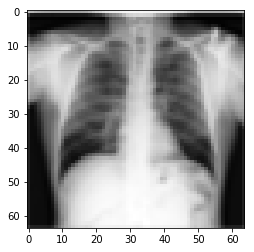

In [7]:
sample = d_kaggle[23]
print(type(sample["PA"]))
plt.imshow(sample["PA"][0], cmap="Greys_r");
plt.savefig('img_example.png')
dict(zip(d_kaggle.pathologies,sample["lab"]))
print(np.min(sample["PA"][0]))

In [12]:
sample['PA'].shape

(1, 64, 64)

In [13]:
out = model(torch.tensor(sample['PA']).unsqueeze(0))
dict(zip(xrv.datasets.default_pathologies,out[0].detach().numpy()))

{'Atelectasis': -3.3624754,
 'Consolidation': -4.9424973,
 'Infiltration': -2.9766097,
 'Pneumothorax': -6.2478614,
 'Edema': -6.6807423,
 'Emphysema': -6.8364315,
 'Fibrosis': -6.204165,
 'Effusion': -4.1891794,
 'Pneumonia': -4.2330613,
 'Pleural_Thickening': -4.366385,
 'Cardiomegaly': -4.5083785,
 'Nodule': -4.2349644,
 'Mass': -5.3744016,
 'Hernia': -7.5134783,
 'Lung Lesion': -5.2975206,
 'Fracture': -3.8900952,
 'Lung Opacity': -2.8499172,
 'Enlarged Cardiomediastinum': -4.370314}

In [20]:
out_temp = torch.sigmoid(out[0,[8,16]]).detach().numpy()
out_temp

array([0.02861274, 0.11389146], dtype=float32)

In [17]:
ind_list = []
for i in range(len(d_kaggle.pathologies)):
    ind_list.append(
        xrv.datasets.default_pathologies.index(d_kaggle.pathologies[i]))
print(ind_list)

[16, 8]


In [27]:
outs = []
labs = []
num_frames = 1000
random_indices = np.random.choice(len(d_kaggle),
                                  size=num_frames,
                                  replace=False)
with torch.no_grad():
    for i in range(num_frames):
        sample = d_kaggle[random_indices[i]]
        labs.append(sample["lab"])
        out = model(torch.from_numpy(sample["PA"]).unsqueeze(0))
        outs.append(out.detach().numpy()[0])

In [31]:
import sklearn, sklearn.metrics
# we look only at the output for the two labels present.
for i in range(len(d_kaggle.pathologies)):
    if len(np.unique(np.asarray(labs)[:, i])) > 1:
        auc = sklearn.metrics.roc_auc_score(
            np.asarray(labs)[:, i],
            sigmoid(np.asarray(outs)[:, ind_list[i]]))
    else:
        auc = "(Only one class observed)"
    print(xrv.datasets.default_pathologies[ind_list[i]], auc)

Lung Opacity 0.6924172693403462
Pneumonia 0.6920657096939148


In [18]:
def find_optimal_thresh(labs, out):
    '''labs: labels. arraylike shape (num_samples,)
        out: NN outputs post sigmoid. arraylike shape (num_samples,) '''
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(labs, out, pos_label=1)
    opt_ind = np.where((tpr-fpr) == np.max(tpr-fpr))
    opt_point = thresholds[opt_ind]
    return opt_point

In [19]:
def normalize_operating_point(x, opt):
    '''x: output post sigmoid for a given label.
        opt: thresh that maximizes tpr-fpr'''
    out = np.zeros(len(x))
    geq_bool = x > opt
    out[geq_bool] = x[geq_bool] / (2.0 * opt)
    out[~geq_bool] = 1.0 - ((1.0 - x[~geq_bool]) / (2.0 * (1.0 - opt)))
    return out

In [20]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

In [21]:
ind = 0 # here just 0/1
out = sigmoid(np.asarray(outs)[:, ind_list[ind]])
labels = np.asarray(labs)[:, ind]
opt_point = find_optimal_thresh(labels, out)
print(opt_point)

NameError: name 'outs' is not defined

In [37]:
normalized_out = normalize_operating_point(out, opt_point)

In [38]:
find_optimal_thresh(labels, normalized_out) # should be 0.5

array([0.5])

Play around with the conv vae to make sure we know how it works.

In [8]:
from drvae.model.ae_model_architecture_generator import *
from drvae.model.vae import ConvVAE

In [9]:
arch_dict = load_handcrafted_arch(ae_arch_json=os.path.join(
    'json_configs', 'ae_arch_new.json'),
                                  input_dim=np.array([1, 64, 64]), # was np.array([1, 223, 223])
                                  n_ae_latents=32,
                                  check_memory=False)

In [10]:
import pprint
pp = pprint.PrettyPrinter()
pp.pprint(arch_dict)

{'ae_batch_norm': True,
 'ae_batch_norm_momentum': 0.1,
 'ae_decoding layer_type': [None],
 'ae_decoding_kernel_size': [5, 5, 5, 5, 5],
 'ae_decoding_last_FF_layer': 0,
 'ae_decoding_layer_type': ['convtranspose',
                            'convtranspose',
                            'convtranspose',
                            'convtranspose',
                            'convtranspose'],
 'ae_decoding_n_channels': [256, 128, 64, 32, 1],
 'ae_decoding_starting_dim': [512, 2, 2],
 'ae_decoding_stride_size': [2, 2, 2, 2, 2],
 'ae_decoding_x_dim': [4, 8, 16, 32, 64],
 'ae_decoding_x_padding': [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
 'ae_decoding_y_dim': [4, 8, 16, 32, 64],
 'ae_decoding_y_padding': [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
 'ae_encoding_kernel_size': [5, 5, 5, 5, 5],
 'ae_encoding_layer_type': ['conv', 'conv', 'conv', 'conv', 'conv'],
 'ae_encoding_n_channels': [32, 64, 128, 256, 512],
 'ae_encoding_stride_size': [2, 2, 2, 2, 2],
 'ae_encoding_x_dim': [32, 16, 8, 4, 

In [11]:
arch_dict["model_class"] = 'vae'
arch_dict['ae_decoding_final_nonlin'] = 'linear' # /or 'sigmoid'

In [12]:
vae = ConvVAE(arch_dict)

gaussian
<function recon_loglike_function at 0x1c3668f400>


In [13]:
print(vae.__str__())


Autoencoder architecture
------------------------
Encoder architecture:
    00: ZeroPad2d(padding=(1, 2, 1, 2), value=0.0)
    01: Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
    02: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    03: LeakyReLU(negative_slope=0.05)
    04: ZeroPad2d(padding=(1, 2, 1, 2), value=0.0)
    05: Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    06: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    07: LeakyReLU(negative_slope=0.05)
    08: ZeroPad2d(padding=(1, 2, 1, 2), value=0.0)
    09: Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    10: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    11: LeakyReLU(negative_slope=0.05)
    12: ZeroPad2d(padding=(1, 2, 1, 2), value=0.0)
    13: Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    14: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    15: LeakyReLU(

the following should run only if you want to change weight inits.

In [12]:
num_frames = 300
random_indices = np.random.choice(len(d_kaggle),
                                  size=num_frames,
                                  replace=False)
subset_dataset = torch.utils.data.Subset(d_kaggle, random_indices)
len(subset_dataset)

300

In [14]:
resdict = {}
vae.fit([None, None, None], 
        [None, None, None], 
        dataset = d_kaggle, # can be susbet_dataset
       epochs = 15,
       log_interval = None,
        output_dir = "vae-output-check",
        torch_seed= int(0),
        batch_size=64,
       )
resdict['vae'] = vae

  0%|          | 0/378 [00:00<?, ?it/s]

None None None None None None
-------------------
fitting vae:  {'Lung Opacity': {0.0: 20672, 1.0: 9555}, 'Pneumonia': {0.0: 20672, 1.0: 9555}}
{'dataset': Kaggle_Dataset num_samples=30227, 'epochs': 15, 'log_interval': None, 'output_dir': 'vae-output-check', 'torch_seed': 0, 'batch_size': 64}
dataset is xray.
 training 44 param groups
Epoch       train-loss  val-loss    train-rmse  val-rmse    train/val-p
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
7.539116
mu is nan:
0
1.3798038
lnvar is nan:
0
1.7071358
data is nan:
0
983.66626
tensor(5.0721e+10, grad_fn=<AddBackward0>)


  0%|          | 1/378 [00:06<38:31,  6.13s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
17.933914
mu is nan:
0
5.341616
lnvar is nan:
0
4.6912403
data is nan:
0
982.2196
tensor(4.8321e+10, grad_fn=<AddBackward0>)


  1%|          | 2/378 [00:12<38:30,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
16.264341
mu is nan:
0
6.134012
lnvar is nan:
0
2.32854
data is nan:
0
939.987
tensor(4.8344e+10, grad_fn=<AddBackward0>)


  1%|          | 3/378 [00:18<38:25,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
20.65726
mu is nan:
0
10.301172
lnvar is nan:
0
3.5374472
data is nan:
0
989.35406
tensor(4.8272e+10, grad_fn=<AddBackward0>)


  1%|          | 4/378 [00:24<38:18,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
17.047277
mu is nan:
0
8.692499
lnvar is nan:
0
3.0367424
data is nan:
0
935.9994
tensor(4.7594e+10, grad_fn=<AddBackward0>)


  1%|▏         | 5/378 [00:30<38:10,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
17.29162
mu is nan:
0
9.980884
lnvar is nan:
0
3.197526
data is nan:
0
971.0267
tensor(4.8144e+10, grad_fn=<AddBackward0>)


  2%|▏         | 6/378 [00:37<38:19,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
17.555965
mu is nan:
0
10.296836
lnvar is nan:
0
3.5072923
data is nan:
0
933.27527
tensor(4.7474e+10, grad_fn=<AddBackward0>)


  2%|▏         | 7/378 [00:43<38:18,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
20.805897
mu is nan:
0
12.229803
lnvar is nan:
0
4.454947
data is nan:
0
954.72327
tensor(5.1434e+10, grad_fn=<AddBackward0>)


  2%|▏         | 8/378 [00:49<38:10,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
19.29048
mu is nan:
0
12.3179035
lnvar is nan:
0
4.237182
data is nan:
0
973.28955
tensor(4.8506e+10, grad_fn=<AddBackward0>)


  2%|▏         | 9/378 [00:55<37:53,  6.16s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
20.401175
mu is nan:
0
13.224321
lnvar is nan:
0
4.200509
data is nan:
0
1015.24
tensor(4.6674e+10, grad_fn=<AddBackward0>)


  3%|▎         | 10/378 [01:01<37:39,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
17.536367
mu is nan:
0
12.43429
lnvar is nan:
0
3.691463
data is nan:
0
930.9129
tensor(4.8968e+10, grad_fn=<AddBackward0>)


  3%|▎         | 11/378 [01:07<37:29,  6.13s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
18.736464
mu is nan:
0
13.471918
lnvar is nan:
0
3.639281
data is nan:
0
986.89813
tensor(4.8222e+10, grad_fn=<AddBackward0>)


  3%|▎         | 12/378 [01:13<37:22,  6.13s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
20.760143
mu is nan:
0
14.675054
lnvar is nan:
0
3.958395
data is nan:
0
954.79486
tensor(5.1957e+10, grad_fn=<AddBackward0>)


  3%|▎         | 13/378 [01:20<37:27,  6.16s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
24.799694
mu is nan:
0
16.478996
lnvar is nan:
0
4.63622
data is nan:
0
938.422
tensor(4.5889e+10, grad_fn=<AddBackward0>)


  4%|▎         | 14/378 [01:26<37:35,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
24.210503
mu is nan:
0
15.757714
lnvar is nan:
0
4.539793
data is nan:
0
964.23627
tensor(5.1702e+10, grad_fn=<AddBackward0>)


  4%|▍         | 15/378 [01:32<37:29,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
27.945381
mu is nan:
0
17.137138
lnvar is nan:
0
5.4436083
data is nan:
0
1005.2394
tensor(4.7523e+10, grad_fn=<AddBackward0>)


  4%|▍         | 16/378 [01:38<37:25,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
22.179628
mu is nan:
0
14.005949
lnvar is nan:
0
4.185346
data is nan:
0
908.03143
tensor(4.9656e+10, grad_fn=<AddBackward0>)


  4%|▍         | 17/378 [01:44<37:10,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
24.103807
mu is nan:
0
15.463389
lnvar is nan:
0
4.209763
data is nan:
0
951.5176
tensor(4.8728e+10, grad_fn=<AddBackward0>)


  5%|▍         | 18/378 [01:50<36:50,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
21.955837
mu is nan:
0
14.804224
lnvar is nan:
0
3.5434098
data is nan:
0
984.08325
tensor(4.7523e+10, grad_fn=<AddBackward0>)


  5%|▌         | 19/378 [01:56<36:28,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
28.028076
mu is nan:
0
18.745708
lnvar is nan:
0
3.8377032
data is nan:
0
965.0152
tensor(4.8469e+10, grad_fn=<AddBackward0>)


  5%|▌         | 20/378 [02:03<36:22,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
21.174372
mu is nan:
0
13.081089
lnvar is nan:
0
2.596817
data is nan:
0
1006.4188
tensor(4.9858e+10, grad_fn=<AddBackward0>)


  6%|▌         | 21/378 [02:09<36:32,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
24.376719
mu is nan:
0
12.604582
lnvar is nan:
0
2.5798151
data is nan:
0
938.60583
tensor(4.6926e+10, grad_fn=<AddBackward0>)


  6%|▌         | 22/378 [02:15<36:19,  6.12s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
24.405867
mu is nan:
0
13.753113
lnvar is nan:
0
2.8692791
data is nan:
0
939.97644
tensor(5.0609e+10, grad_fn=<AddBackward0>)


  6%|▌         | 23/378 [02:21<36:20,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
27.787056
mu is nan:
0
12.987703
lnvar is nan:
0
2.3507059
data is nan:
0
942.85944
tensor(4.8708e+10, grad_fn=<AddBackward0>)


  6%|▋         | 24/378 [02:27<36:20,  6.16s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
30.013485
mu is nan:
0
13.219209
lnvar is nan:
0
1.8263116
data is nan:
0
935.3486
tensor(4.8650e+10, grad_fn=<AddBackward0>)


  7%|▋         | 25/378 [02:33<36:08,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
33.400936
mu is nan:
0
14.19701
lnvar is nan:
0
1.113478
data is nan:
0
1001.79944
tensor(4.6115e+10, grad_fn=<AddBackward0>)


  7%|▋         | 26/378 [02:40<36:18,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
30.235027
mu is nan:
0
14.123027
lnvar is nan:
0
0.7659679
data is nan:
0
956.0886
tensor(4.6672e+10, grad_fn=<AddBackward0>)


  7%|▋         | 27/378 [02:46<36:06,  6.17s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
32.406803
mu is nan:
0
13.972334
lnvar is nan:
0
0.94254446
data is nan:
0
950.791
tensor(4.4063e+10, grad_fn=<AddBackward0>)


  7%|▋         | 28/378 [02:52<35:41,  6.12s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
32.806988
mu is nan:
0
14.026161
lnvar is nan:
0
0.5577894
data is nan:
0
967.154
tensor(4.6691e+10, grad_fn=<AddBackward0>)


  8%|▊         | 29/378 [02:58<35:11,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
31.494751
mu is nan:
0
14.686878
lnvar is nan:
0
0.38685673
data is nan:
0
973.3328
tensor(4.4504e+10, grad_fn=<AddBackward0>)


  8%|▊         | 30/378 [03:04<35:05,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
31.515596
mu is nan:
0
13.160747
lnvar is nan:
0
2.2774444
data is nan:
0
928.48944
tensor(4.5608e+10, grad_fn=<AddBackward0>)


  8%|▊         | 31/378 [03:10<35:32,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
34.611397
mu is nan:
0
13.846516
lnvar is nan:
0
0.44564426
data is nan:
0
967.6295
tensor(4.5970e+10, grad_fn=<AddBackward0>)


  8%|▊         | 32/378 [03:17<36:02,  6.25s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
31.999016
mu is nan:
0
12.238877
lnvar is nan:
0
0.4343269
data is nan:
0
943.2908
tensor(4.8284e+10, grad_fn=<AddBackward0>)


  9%|▊         | 33/378 [03:23<35:49,  6.23s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
41.609165
mu is nan:
0
13.495869
lnvar is nan:
0
1.0828657
data is nan:
0
931.15625
tensor(4.7280e+10, grad_fn=<AddBackward0>)


  9%|▉         | 34/378 [03:29<35:43,  6.23s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
45.6353
mu is nan:
0
12.880753
lnvar is nan:
0
0.01601161
data is nan:
0
999.3913
tensor(4.9610e+10, grad_fn=<AddBackward0>)


  9%|▉         | 35/378 [03:35<35:37,  6.23s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
44.326622
mu is nan:
0
13.788602
lnvar is nan:
0
0.21236297
data is nan:
0
982.4936
tensor(4.5383e+10, grad_fn=<AddBackward0>)


 10%|▉         | 36/378 [03:41<35:23,  6.21s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
42.053333
mu is nan:
0
12.729952
lnvar is nan:
0
0.4610011
data is nan:
0
952.7854
tensor(4.8733e+10, grad_fn=<AddBackward0>)


 10%|▉         | 37/378 [03:47<35:08,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
47.49395
mu is nan:
0
14.203793
lnvar is nan:
0
-0.22147682
data is nan:
0
990.48785
tensor(4.5365e+10, grad_fn=<AddBackward0>)


 10%|█         | 38/378 [03:54<34:47,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
41.804775
mu is nan:
0
11.889379
lnvar is nan:
0
-0.53163695
data is nan:
0
932.5191
tensor(4.8434e+10, grad_fn=<AddBackward0>)


 10%|█         | 39/378 [04:00<34:32,  6.11s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
42.852566
mu is nan:
0
12.921568
lnvar is nan:
0
-0.3797647
data is nan:
0
952.6359
tensor(4.6862e+10, grad_fn=<AddBackward0>)


 11%|█         | 40/378 [04:06<34:18,  6.09s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
38.895912
mu is nan:
0
12.599305
lnvar is nan:
0
-0.61535746
data is nan:
0
932.5087
tensor(4.2472e+10, grad_fn=<AddBackward0>)


 11%|█         | 41/378 [04:12<34:29,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
39.889095
mu is nan:
0
12.368576
lnvar is nan:
0
-0.4110273
data is nan:
0
942.04236
tensor(4.7042e+10, grad_fn=<AddBackward0>)


 11%|█         | 42/378 [04:18<34:27,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
40.520157
mu is nan:
0
12.75477
lnvar is nan:
0
0.3364519
data is nan:
0
982.13666
tensor(4.9585e+10, grad_fn=<AddBackward0>)


 11%|█▏        | 43/378 [04:24<34:25,  6.17s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
43.403805
mu is nan:
0
13.864412
lnvar is nan:
0
-0.5951671
data is nan:
0
913.0067
tensor(4.7413e+10, grad_fn=<AddBackward0>)


 12%|█▏        | 44/378 [04:30<34:27,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
46.070164
mu is nan:
0
14.032732
lnvar is nan:
0
0.42368037
data is nan:
0
948.66815
tensor(4.6960e+10, grad_fn=<AddBackward0>)


 12%|█▏        | 45/378 [04:37<34:21,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
46.627735
mu is nan:
0
11.850702
lnvar is nan:
0
-1.0520267
data is nan:
0
948.9397
tensor(4.9289e+10, grad_fn=<AddBackward0>)


 12%|█▏        | 46/378 [04:43<34:11,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
47.692303
mu is nan:
0
13.602205
lnvar is nan:
0
-1.0123708
data is nan:
0
929.3108
tensor(4.9276e+10, grad_fn=<AddBackward0>)


 12%|█▏        | 47/378 [04:49<34:11,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
47.77253
mu is nan:
0
12.532942
lnvar is nan:
0
0.17336142
data is nan:
0
967.0897
tensor(4.7850e+10, grad_fn=<AddBackward0>)


 13%|█▎        | 48/378 [04:55<34:06,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
45.838528
mu is nan:
0
12.888046
lnvar is nan:
0
0.8809464
data is nan:
0
954.81445
tensor(4.7588e+10, grad_fn=<AddBackward0>)


 13%|█▎        | 49/378 [05:02<34:06,  6.22s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
41.65903
mu is nan:
0
11.63182
lnvar is nan:
0
-0.87621546
data is nan:
0
948.0488
tensor(4.8998e+10, grad_fn=<AddBackward0>)


 13%|█▎        | 50/378 [05:11<38:40,  7.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
45.536476
mu is nan:
0
11.230423
lnvar is nan:
0
0.11894551
data is nan:
0
932.7588
tensor(4.7251e+10, grad_fn=<AddBackward0>)


 13%|█▎        | 51/378 [05:17<36:54,  6.77s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
48.451607
mu is nan:
0
11.224476
lnvar is nan:
0
1.9799545
data is nan:
0
983.05365
tensor(5.1021e+10, grad_fn=<AddBackward0>)


 14%|█▍        | 52/378 [05:23<35:40,  6.57s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.81819
mu is nan:
0
11.261612
lnvar is nan:
0
2.2180882
data is nan:
0
965.61945
tensor(4.2264e+10, grad_fn=<AddBackward0>)


 14%|█▍        | 53/378 [05:29<34:36,  6.39s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
44.756836
mu is nan:
0
9.691036
lnvar is nan:
0
-0.33696795
data is nan:
0
903.55743
tensor(4.6430e+10, grad_fn=<AddBackward0>)


 14%|█▍        | 54/378 [05:35<33:57,  6.29s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
49.940994
mu is nan:
0
10.0659685
lnvar is nan:
0
0.18701571
data is nan:
0
905.20935
tensor(4.8298e+10, grad_fn=<AddBackward0>)


 15%|█▍        | 55/378 [05:41<33:24,  6.21s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
51.78253
mu is nan:
0
10.897004
lnvar is nan:
0
-0.6235138
data is nan:
0
960.32227
tensor(4.6092e+10, grad_fn=<AddBackward0>)


 15%|█▍        | 56/378 [05:47<32:58,  6.14s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.134773
mu is nan:
0
11.980452
lnvar is nan:
0
-0.55997354
data is nan:
0
908.4066
tensor(4.4485e+10, grad_fn=<AddBackward0>)


 15%|█▌        | 57/378 [05:53<32:40,  6.11s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.937054
mu is nan:
0
10.9179945
lnvar is nan:
0
-0.23662375
data is nan:
0
956.2264
tensor(4.7426e+10, grad_fn=<AddBackward0>)


 15%|█▌        | 58/378 [05:59<32:26,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
54.210796
mu is nan:
0
11.988414
lnvar is nan:
0
-0.20847936
data is nan:
0
949.6075
tensor(4.6880e+10, grad_fn=<AddBackward0>)


 16%|█▌        | 59/378 [06:05<32:19,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.036766
mu is nan:
0
12.280578
lnvar is nan:
0
0.18318821
data is nan:
0
970.22314
tensor(4.9880e+10, grad_fn=<AddBackward0>)


 16%|█▌        | 60/378 [06:11<32:09,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.93664
mu is nan:
0
12.567917
lnvar is nan:
0
-0.04884821
data is nan:
0
982.0385
tensor(4.8392e+10, grad_fn=<AddBackward0>)


 16%|█▌        | 61/378 [06:17<32:06,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
55.309196
mu is nan:
0
13.373742
lnvar is nan:
0
-0.36158112
data is nan:
0
1014.6969
tensor(4.3296e+10, grad_fn=<AddBackward0>)


 16%|█▋        | 62/378 [06:23<32:03,  6.09s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
53.071297
mu is nan:
0
13.228284
lnvar is nan:
0
-0.23699257
data is nan:
0
956.99835
tensor(4.4661e+10, grad_fn=<AddBackward0>)


 17%|█▋        | 63/378 [06:29<32:05,  6.11s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
52.23503
mu is nan:
0
13.229555
lnvar is nan:
0
-0.5914151
data is nan:
0
950.8769
tensor(4.7227e+10, grad_fn=<AddBackward0>)


 17%|█▋        | 64/378 [06:35<31:54,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
59.402588
mu is nan:
0
14.291256
lnvar is nan:
0
-0.68491673
data is nan:
0
1015.9686
tensor(4.4126e+10, grad_fn=<AddBackward0>)


 17%|█▋        | 65/378 [06:42<31:47,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
63.555843
mu is nan:
0
13.138383
lnvar is nan:
0
-0.33430722
data is nan:
0
993.19434
tensor(4.8133e+10, grad_fn=<AddBackward0>)


 17%|█▋        | 66/378 [06:48<31:34,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
62.406696
mu is nan:
0
13.35417
lnvar is nan:
0
-0.68701625
data is nan:
0
958.80005
tensor(4.5409e+10, grad_fn=<AddBackward0>)


 18%|█▊        | 67/378 [06:54<31:29,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
65.76754
mu is nan:
0
12.378125
lnvar is nan:
0
-0.736849
data is nan:
0
941.6552
tensor(4.8396e+10, grad_fn=<AddBackward0>)


 18%|█▊        | 68/378 [07:00<31:20,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
67.21739
mu is nan:
0
12.947643
lnvar is nan:
0
-0.618332
data is nan:
0
1015.9752
tensor(5.0296e+10, grad_fn=<AddBackward0>)


 18%|█▊        | 69/378 [07:06<31:13,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
60.84423
mu is nan:
0
13.388163
lnvar is nan:
0
0.58583856
data is nan:
0
973.6555
tensor(4.5773e+10, grad_fn=<AddBackward0>)


 19%|█▊        | 70/378 [07:12<31:09,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
60.357777
mu is nan:
0
14.498981
lnvar is nan:
0
-0.38595653
data is nan:
0
968.5103
tensor(5.0280e+10, grad_fn=<AddBackward0>)


 19%|█▉        | 71/378 [07:18<31:02,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
61.04794
mu is nan:
0
13.265334
lnvar is nan:
0
-0.4508823
data is nan:
0
952.542
tensor(5.0153e+10, grad_fn=<AddBackward0>)


 19%|█▉        | 72/378 [07:24<30:52,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
59.48794
mu is nan:
0
13.911641
lnvar is nan:
0
0.17640227
data is nan:
0
905.6455
tensor(4.7769e+10, grad_fn=<AddBackward0>)


 19%|█▉        | 73/378 [07:30<30:49,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
61.421
mu is nan:
0
12.863295
lnvar is nan:
0
0.360861
data is nan:
0
902.7373
tensor(4.7960e+10, grad_fn=<AddBackward0>)


 20%|█▉        | 74/378 [07:36<30:40,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
73.18609
mu is nan:
0
15.671316
lnvar is nan:
0
-0.42349637
data is nan:
0
975.5349
tensor(4.0315e+10, grad_fn=<AddBackward0>)


 20%|█▉        | 75/378 [07:42<30:29,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
72.64816
mu is nan:
0
13.317329
lnvar is nan:
0
-0.36633587
data is nan:
0
924.9552
tensor(4.4508e+10, grad_fn=<AddBackward0>)


 20%|██        | 76/378 [07:48<30:24,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
75.004776
mu is nan:
0
14.909006
lnvar is nan:
0
-0.69202644
data is nan:
0
960.9137
tensor(4.5655e+10, grad_fn=<AddBackward0>)


 20%|██        | 77/378 [07:54<30:19,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
69.69039
mu is nan:
0
13.749252
lnvar is nan:
0
-0.66827536
data is nan:
0
922.1172
tensor(4.7450e+10, grad_fn=<AddBackward0>)


 21%|██        | 78/378 [08:00<30:11,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
70.55667
mu is nan:
0
12.629066
lnvar is nan:
0
-0.10396236
data is nan:
0
966.95435
tensor(4.8379e+10, grad_fn=<AddBackward0>)


 21%|██        | 79/378 [08:06<30:05,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
67.47565
mu is nan:
0
14.706689
lnvar is nan:
0
-0.3977726
data is nan:
0
992.0731
tensor(4.5267e+10, grad_fn=<AddBackward0>)


 21%|██        | 80/378 [08:12<30:00,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
69.50727
mu is nan:
0
15.691267
lnvar is nan:
0
-0.5007841
data is nan:
0
953.9007
tensor(4.6078e+10, grad_fn=<AddBackward0>)


 21%|██▏       | 81/378 [08:18<29:56,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
68.001884
mu is nan:
0
13.226966
lnvar is nan:
0
0.20344728
data is nan:
0
996.4923
tensor(4.4490e+10, grad_fn=<AddBackward0>)


 22%|██▏       | 82/378 [08:24<29:49,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
69.37757
mu is nan:
0
12.19215
lnvar is nan:
0
1.2498193
data is nan:
0
934.6789
tensor(5.0543e+10, grad_fn=<AddBackward0>)


 22%|██▏       | 83/378 [08:31<30:04,  6.12s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
76.322784
mu is nan:
0
15.2769985
lnvar is nan:
0
-0.7701495
data is nan:
0
982.73773
tensor(4.6936e+10, grad_fn=<AddBackward0>)


 22%|██▏       | 84/378 [08:37<29:51,  6.09s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
71.415634
mu is nan:
0
12.78493
lnvar is nan:
0
-0.7157568
data is nan:
0
943.5089
tensor(4.4851e+10, grad_fn=<AddBackward0>)


 22%|██▏       | 85/378 [08:43<29:41,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
83.47792
mu is nan:
0
13.9566555
lnvar is nan:
0
-0.8531792
data is nan:
0
949.88184
tensor(4.1425e+10, grad_fn=<AddBackward0>)


 23%|██▎       | 86/378 [08:49<29:29,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
72.71672
mu is nan:
0
13.375984
lnvar is nan:
0
-1.1241549
data is nan:
0
963.45044
tensor(4.6259e+10, grad_fn=<AddBackward0>)


 23%|██▎       | 87/378 [08:55<29:21,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
72.42988
mu is nan:
0
20.578838
lnvar is nan:
0
-0.73861945
data is nan:
0
956.5912
tensor(4.4568e+10, grad_fn=<AddBackward0>)


 23%|██▎       | 88/378 [09:01<29:11,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
69.94074
mu is nan:
0
12.275993
lnvar is nan:
0
-1.6793457
data is nan:
0
954.43823
tensor(4.9209e+10, grad_fn=<AddBackward0>)


 24%|██▎       | 89/378 [09:07<29:01,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
68.00949
mu is nan:
0
15.454369
lnvar is nan:
0
-0.97972
data is nan:
0
947.89594
tensor(4.4469e+10, grad_fn=<AddBackward0>)


 24%|██▍       | 90/378 [09:13<29:00,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
71.658745
mu is nan:
0
12.263582
lnvar is nan:
0
-0.6179673
data is nan:
0
983.0716
tensor(4.5839e+10, grad_fn=<AddBackward0>)


 24%|██▍       | 91/378 [09:19<28:55,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
76.530205
mu is nan:
0
13.33728
lnvar is nan:
0
1.4402131
data is nan:
0
996.8802
tensor(4.5839e+10, grad_fn=<AddBackward0>)


 24%|██▍       | 92/378 [09:25<28:58,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
79.42512
mu is nan:
0
13.050129
lnvar is nan:
0
-1.008447
data is nan:
0
973.3341
tensor(4.5531e+10, grad_fn=<AddBackward0>)


 25%|██▍       | 93/378 [09:31<29:05,  6.13s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
85.296486
mu is nan:
0
13.224063
lnvar is nan:
0
-1.2571039
data is nan:
0
947.4546
tensor(4.5510e+10, grad_fn=<AddBackward0>)


 25%|██▍       | 94/378 [09:37<29:01,  6.13s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
83.96218
mu is nan:
0
15.116199
lnvar is nan:
0
1.0790973
data is nan:
0
944.4548
tensor(4.4540e+10, grad_fn=<AddBackward0>)


 25%|██▌       | 95/378 [09:43<28:46,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
76.71813
mu is nan:
0
12.182963
lnvar is nan:
0
-1.4553587
data is nan:
0
972.5785
tensor(4.8190e+10, grad_fn=<AddBackward0>)


 25%|██▌       | 96/378 [09:49<28:35,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
82.71434
mu is nan:
0
13.366267
lnvar is nan:
0
0.7623532
data is nan:
0
942.0846
tensor(4.7506e+10, grad_fn=<AddBackward0>)


 26%|██▌       | 97/378 [09:56<28:24,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
80.25442
mu is nan:
0
13.595764
lnvar is nan:
0
-1.9963021
data is nan:
0
1010.6501
tensor(4.5682e+10, grad_fn=<AddBackward0>)


 26%|██▌       | 98/378 [10:02<28:17,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
87.55935
mu is nan:
0
12.588581
lnvar is nan:
0
-1.4198284
data is nan:
0
969.0838
tensor(4.4476e+10, grad_fn=<AddBackward0>)


 26%|██▌       | 99/378 [10:08<28:09,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
82.207344
mu is nan:
0
13.895509
lnvar is nan:
0
-1.5419981
data is nan:
0
983.03467
tensor(4.4730e+10, grad_fn=<AddBackward0>)


 26%|██▋       | 100/378 [10:14<28:01,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
88.12714
mu is nan:
0
13.012419
lnvar is nan:
0
-2.0630078
data is nan:
0
930.83484
tensor(4.4208e+10, grad_fn=<AddBackward0>)


 27%|██▋       | 101/378 [10:20<27:51,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
78.556725
mu is nan:
0
12.988335
lnvar is nan:
0
-1.2857391
data is nan:
0
909.3695
tensor(4.6224e+10, grad_fn=<AddBackward0>)


 27%|██▋       | 102/378 [10:26<27:45,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
84.01437
mu is nan:
0
12.796391
lnvar is nan:
0
-1.4545692
data is nan:
0
987.09766
tensor(4.6539e+10, grad_fn=<AddBackward0>)


 27%|██▋       | 103/378 [10:32<27:36,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
84.679855
mu is nan:
0
11.507489
lnvar is nan:
0
-1.788357
data is nan:
0
960.2899
tensor(4.2274e+10, grad_fn=<AddBackward0>)


 28%|██▊       | 104/378 [10:38<27:28,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
88.15765
mu is nan:
0
14.171738
lnvar is nan:
0
-1.5993752
data is nan:
0
945.1354
tensor(4.5024e+10, grad_fn=<AddBackward0>)


 28%|██▊       | 105/378 [10:44<27:23,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
86.708176
mu is nan:
0
12.678251
lnvar is nan:
0
-2.2378101
data is nan:
0
967.12256
tensor(4.7125e+10, grad_fn=<AddBackward0>)


 28%|██▊       | 106/378 [10:50<27:16,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
90.88949
mu is nan:
0
12.062912
lnvar is nan:
0
-1.0993806
data is nan:
0
940.0265
tensor(4.5999e+10, grad_fn=<AddBackward0>)


 28%|██▊       | 107/378 [10:56<27:14,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
92.22929
mu is nan:
0
16.380808
lnvar is nan:
0
-2.362839
data is nan:
0
967.6173
tensor(4.8676e+10, grad_fn=<AddBackward0>)


 29%|██▊       | 108/378 [11:02<27:03,  6.01s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
97.17872
mu is nan:
0
12.387589
lnvar is nan:
0
-0.08132231
data is nan:
0
963.07367
tensor(4.8521e+10, grad_fn=<AddBackward0>)


 29%|██▉       | 109/378 [11:08<27:00,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
98.33158
mu is nan:
0
14.416789
lnvar is nan:
0
-1.1145229
data is nan:
0
954.9196
tensor(4.6669e+10, grad_fn=<AddBackward0>)


 29%|██▉       | 110/378 [11:14<26:56,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
112.30843
mu is nan:
0
14.191017
lnvar is nan:
0
-1.8011097
data is nan:
0
1006.7162
tensor(4.7071e+10, grad_fn=<AddBackward0>)


 29%|██▉       | 111/378 [11:20<26:49,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
105.22048
mu is nan:
0
12.490472
lnvar is nan:
0
-2.098715
data is nan:
0
977.7595
tensor(4.3950e+10, grad_fn=<AddBackward0>)


 30%|██▉       | 112/378 [11:26<26:50,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
97.43697
mu is nan:
0
21.195599
lnvar is nan:
0
0.5087004
data is nan:
0
967.8318
tensor(4.7694e+10, grad_fn=<AddBackward0>)


 30%|██▉       | 113/378 [11:32<26:42,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
102.73408
mu is nan:
0
18.01095
lnvar is nan:
0
-1.9542391
data is nan:
0
952.1019
tensor(4.5365e+10, grad_fn=<AddBackward0>)


 30%|███       | 114/378 [11:38<26:38,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
94.60802
mu is nan:
0
13.286327
lnvar is nan:
0
-2.6639626
data is nan:
0
969.8244
tensor(4.8328e+10, grad_fn=<AddBackward0>)


 30%|███       | 115/378 [11:44<26:28,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
93.36502
mu is nan:
0
12.740002
lnvar is nan:
0
-2.09612
data is nan:
0
963.6643
tensor(4.4552e+10, grad_fn=<AddBackward0>)


 31%|███       | 116/378 [11:50<26:18,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
92.41596
mu is nan:
0
13.628176
lnvar is nan:
0
-1.6861179
data is nan:
0
948.6746
tensor(4.3932e+10, grad_fn=<AddBackward0>)


 31%|███       | 117/378 [11:56<26:14,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
102.96387
mu is nan:
0
16.27042
lnvar is nan:
0
1.6311114
data is nan:
0
945.67206
tensor(4.3381e+10, grad_fn=<AddBackward0>)


 31%|███       | 118/378 [12:02<26:07,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
100.299225
mu is nan:
0
13.02788
lnvar is nan:
0
-2.0726333
data is nan:
0
948.42065
tensor(4.2979e+10, grad_fn=<AddBackward0>)


 31%|███▏      | 119/378 [12:08<26:01,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
108.8095
mu is nan:
0
14.167678
lnvar is nan:
0
-1.7338457
data is nan:
0
974.1087
tensor(4.8009e+10, grad_fn=<AddBackward0>)


 32%|███▏      | 120/378 [12:14<25:54,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
105.733086
mu is nan:
0
13.253904
lnvar is nan:
0
-1.1287277
data is nan:
0
945.496
tensor(4.4384e+10, grad_fn=<AddBackward0>)


 32%|███▏      | 121/378 [12:20<25:48,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
105.44575
mu is nan:
0
13.565361
lnvar is nan:
0
-2.165715
data is nan:
0
918.581
tensor(3.9742e+10, grad_fn=<AddBackward0>)


 32%|███▏      | 122/378 [12:26<25:38,  6.01s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
102.83423
mu is nan:
0
13.341036
lnvar is nan:
0
-1.7117757
data is nan:
0
929.2099
tensor(4.0934e+10, grad_fn=<AddBackward0>)


 33%|███▎      | 123/378 [12:32<25:33,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
111.07859
mu is nan:
0
13.5089855
lnvar is nan:
0
-1.7881972
data is nan:
0
934.6056
tensor(4.3623e+10, grad_fn=<AddBackward0>)


 33%|███▎      | 124/378 [12:38<25:30,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
108.44134
mu is nan:
0
12.585789
lnvar is nan:
0
-2.0386465
data is nan:
0
919.58185
tensor(4.4473e+10, grad_fn=<AddBackward0>)


 33%|███▎      | 125/378 [12:44<25:26,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
116.31194
mu is nan:
0
14.595561
lnvar is nan:
0
-1.9652421
data is nan:
0
944.6653
tensor(4.3179e+10, grad_fn=<AddBackward0>)


 33%|███▎      | 126/378 [12:50<25:24,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
113.340546
mu is nan:
0
14.500898
lnvar is nan:
0
-1.9789462
data is nan:
0
955.73737
tensor(4.5778e+10, grad_fn=<AddBackward0>)


 34%|███▎      | 127/378 [12:56<25:18,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
106.61621
mu is nan:
0
12.976828
lnvar is nan:
0
-2.1360788
data is nan:
0
950.213
tensor(4.6407e+10, grad_fn=<AddBackward0>)


 34%|███▍      | 128/378 [13:02<25:11,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
111.99686
mu is nan:
0
13.719356
lnvar is nan:
0
-2.2681117
data is nan:
0
952.34625
tensor(4.3644e+10, grad_fn=<AddBackward0>)


 34%|███▍      | 129/378 [13:09<25:20,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
101.45893
mu is nan:
0
13.53458
lnvar is nan:
0
-2.0434368
data is nan:
0
964.63226
tensor(4.7796e+10, grad_fn=<AddBackward0>)


 34%|███▍      | 130/378 [13:15<25:24,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
107.36298
mu is nan:
0
13.572604
lnvar is nan:
0
-2.54459
data is nan:
0
972.3193
tensor(4.5592e+10, grad_fn=<AddBackward0>)


 35%|███▍      | 131/378 [13:21<25:27,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
117.261215
mu is nan:
0
16.843937
lnvar is nan:
0
-2.4176114
data is nan:
0
996.41235
tensor(4.3679e+10, grad_fn=<AddBackward0>)


 35%|███▍      | 132/378 [13:27<25:25,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
110.88257
mu is nan:
0
14.396065
lnvar is nan:
0
-2.0944943
data is nan:
0
972.6832
tensor(4.1040e+10, grad_fn=<AddBackward0>)


 35%|███▌      | 133/378 [13:34<25:16,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
102.46873
mu is nan:
0
13.732824
lnvar is nan:
0
-2.108234
data is nan:
0
948.7959
tensor(4.1809e+10, grad_fn=<AddBackward0>)


 35%|███▌      | 134/378 [13:40<25:07,  6.18s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
120.439095
mu is nan:
0
14.894347
lnvar is nan:
0
-2.6693165
data is nan:
0
949.3071
tensor(4.3405e+10, grad_fn=<AddBackward0>)


 36%|███▌      | 135/378 [13:46<24:54,  6.15s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
119.048416
mu is nan:
0
21.023993
lnvar is nan:
0
-1.5116987
data is nan:
0
988.71716
tensor(4.7415e+10, grad_fn=<AddBackward0>)


 36%|███▌      | 136/378 [13:52<24:40,  6.12s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
117.90142
mu is nan:
0
15.397535
lnvar is nan:
0
-2.2344232
data is nan:
0
945.8357
tensor(4.4208e+10, grad_fn=<AddBackward0>)


 36%|███▌      | 137/378 [13:58<24:30,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
135.0988
mu is nan:
0
22.137428
lnvar is nan:
0
-2.3855863
data is nan:
0
967.6361
tensor(4.4884e+10, grad_fn=<AddBackward0>)


 37%|███▋      | 138/378 [14:04<24:16,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
117.77229
mu is nan:
0
13.444166
lnvar is nan:
0
-2.2079313
data is nan:
0
991.10376
tensor(4.5937e+10, grad_fn=<AddBackward0>)


 37%|███▋      | 139/378 [14:10<24:06,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
106.20264
mu is nan:
0
16.343174
lnvar is nan:
0
-2.06529
data is nan:
0
995.7273
tensor(4.3749e+10, grad_fn=<AddBackward0>)


 37%|███▋      | 140/378 [14:16<23:57,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
112.241234
mu is nan:
0
14.83642
lnvar is nan:
0
-2.673725
data is nan:
0
989.4029
tensor(4.4154e+10, grad_fn=<AddBackward0>)


 37%|███▋      | 141/378 [14:22<23:53,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
116.67502
mu is nan:
0
13.079727
lnvar is nan:
0
-3.1656842
data is nan:
0
901.2545
tensor(4.0024e+10, grad_fn=<AddBackward0>)


 38%|███▊      | 142/378 [14:28<23:47,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
129.28781
mu is nan:
0
14.479013
lnvar is nan:
0
-2.198719
data is nan:
0
983.4946
tensor(4.1653e+10, grad_fn=<AddBackward0>)


 38%|███▊      | 143/378 [14:34<23:39,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
122.040016
mu is nan:
0
14.586632
lnvar is nan:
0
-0.7613744
data is nan:
0
955.5836
tensor(4.3908e+10, grad_fn=<AddBackward0>)


 38%|███▊      | 144/378 [14:40<23:34,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
136.51886
mu is nan:
0
12.705498
lnvar is nan:
0
-3.1401434
data is nan:
0
983.5073
tensor(4.2972e+10, grad_fn=<AddBackward0>)


 38%|███▊      | 145/378 [14:46<23:29,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
133.41649
mu is nan:
0
13.940109
lnvar is nan:
0
-2.5286252
data is nan:
0
962.384
tensor(4.2255e+10, grad_fn=<AddBackward0>)


 39%|███▊      | 146/378 [14:52<23:21,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
123.93572
mu is nan:
0
19.79187
lnvar is nan:
0
-2.0197015
data is nan:
0
945.08167
tensor(4.3226e+10, grad_fn=<AddBackward0>)


 39%|███▉      | 147/378 [14:58<23:16,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
117.14548
mu is nan:
0
15.051496
lnvar is nan:
0
-1.372977
data is nan:
0
964.954
tensor(4.5083e+10, grad_fn=<AddBackward0>)


 39%|███▉      | 148/378 [15:04<23:08,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
122.366135
mu is nan:
0
13.382528
lnvar is nan:
0
-3.674205
data is nan:
0
948.847
tensor(4.4691e+10, grad_fn=<AddBackward0>)


 39%|███▉      | 149/378 [15:10<23:01,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
129.64725
mu is nan:
0
12.553463
lnvar is nan:
0
-1.5280521
data is nan:
0
928.9734
tensor(4.4376e+10, grad_fn=<AddBackward0>)


 40%|███▉      | 150/378 [15:16<22:56,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
140.74907
mu is nan:
0
17.602287
lnvar is nan:
0
-1.2627064
data is nan:
0
948.13684
tensor(4.5410e+10, grad_fn=<AddBackward0>)


 40%|███▉      | 151/378 [15:23<22:55,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
129.28305
mu is nan:
0
15.072872
lnvar is nan:
0
-1.9420218
data is nan:
0
990.78296
tensor(4.3115e+10, grad_fn=<AddBackward0>)


 40%|████      | 152/378 [15:29<22:45,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
122.97623
mu is nan:
0
18.590366
lnvar is nan:
0
0.1497992
data is nan:
0
958.08624
tensor(4.2354e+10, grad_fn=<AddBackward0>)


 40%|████      | 153/378 [15:35<22:38,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
128.71603
mu is nan:
0
15.482315
lnvar is nan:
0
-1.5126765
data is nan:
0
958.87836
tensor(4.2176e+10, grad_fn=<AddBackward0>)


 41%|████      | 154/378 [15:41<22:31,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
119.86446
mu is nan:
0
13.665635
lnvar is nan:
0
-2.7103305
data is nan:
0
971.85034
tensor(4.2352e+10, grad_fn=<AddBackward0>)


 41%|████      | 155/378 [15:47<22:25,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
130.30916
mu is nan:
0
15.210003
lnvar is nan:
0
0.31249666
data is nan:
0
947.9437
tensor(4.4886e+10, grad_fn=<AddBackward0>)


 41%|████▏     | 156/378 [15:53<22:20,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
136.15137
mu is nan:
0
13.224274
lnvar is nan:
0
-0.9867979
data is nan:
0
948.1192
tensor(4.2749e+10, grad_fn=<AddBackward0>)


 42%|████▏     | 157/378 [15:59<22:16,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
145.82156
mu is nan:
0
14.319568
lnvar is nan:
0
-1.5205095
data is nan:
0
964.0647
tensor(4.4290e+10, grad_fn=<AddBackward0>)


 42%|████▏     | 158/378 [16:05<22:07,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
148.09283
mu is nan:
0
15.611686
lnvar is nan:
0
-2.1418962
data is nan:
0
959.65247
tensor(4.5128e+10, grad_fn=<AddBackward0>)


 42%|████▏     | 159/378 [16:11<22:02,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
160.84744
mu is nan:
0
15.565117
lnvar is nan:
0
-1.2877253
data is nan:
0
1015.85565
tensor(4.3975e+10, grad_fn=<AddBackward0>)


 42%|████▏     | 160/378 [16:17<21:56,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
149.79462
mu is nan:
0
13.909107
lnvar is nan:
0
-1.389028
data is nan:
0
973.3328
tensor(4.5273e+10, grad_fn=<AddBackward0>)


 43%|████▎     | 161/378 [16:23<21:48,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
127.87535
mu is nan:
0
13.512686
lnvar is nan:
0
0.05790805
data is nan:
0
900.13434
tensor(4.3516e+10, grad_fn=<AddBackward0>)


 43%|████▎     | 162/378 [16:29<21:41,  6.02s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
128.95958
mu is nan:
0
13.596492
lnvar is nan:
0
-2.3866067
data is nan:
0
950.5753
tensor(4.6553e+10, grad_fn=<AddBackward0>)


 43%|████▎     | 163/378 [16:35<21:39,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
136.04388
mu is nan:
0
17.252419
lnvar is nan:
0
-1.5111703
data is nan:
0
987.0089
tensor(4.5661e+10, grad_fn=<AddBackward0>)


 43%|████▎     | 164/378 [16:41<21:32,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
138.7046
mu is nan:
0
15.902566
lnvar is nan:
0
-1.67695
data is nan:
0
978.3325
tensor(4.4718e+10, grad_fn=<AddBackward0>)


 44%|████▎     | 165/378 [16:47<21:26,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
136.33815
mu is nan:
0
14.738086
lnvar is nan:
0
-0.55616313
data is nan:
0
938.9681
tensor(4.5778e+10, grad_fn=<AddBackward0>)


 44%|████▍     | 166/378 [16:53<21:24,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
147.32805
mu is nan:
0
15.127703
lnvar is nan:
0
-2.8308809
data is nan:
0
975.28937
tensor(4.2949e+10, grad_fn=<AddBackward0>)


 44%|████▍     | 167/378 [16:59<21:16,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
124.50668
mu is nan:
0
13.81411
lnvar is nan:
0
-1.845598
data is nan:
0
917.56683
tensor(4.5096e+10, grad_fn=<AddBackward0>)


 44%|████▍     | 168/378 [17:05<21:09,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
141.35468
mu is nan:
0
13.330626
lnvar is nan:
0
-2.3615503
data is nan:
0
983.0694
tensor(4.2465e+10, grad_fn=<AddBackward0>)


 45%|████▍     | 169/378 [17:11<21:02,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
135.58911
mu is nan:
0
19.85072
lnvar is nan:
0
-2.6828866
data is nan:
0
952.9073
tensor(4.4122e+10, grad_fn=<AddBackward0>)


 45%|████▍     | 170/378 [17:17<20:55,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
139.75061
mu is nan:
0
13.357698
lnvar is nan:
0
-2.0207777
data is nan:
0
948.27655
tensor(4.2810e+10, grad_fn=<AddBackward0>)


 45%|████▌     | 171/378 [17:23<20:48,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
155.73497
mu is nan:
0
16.34099
lnvar is nan:
0
-2.1299815
data is nan:
0
971.2032
tensor(4.3043e+10, grad_fn=<AddBackward0>)


 46%|████▌     | 172/378 [17:29<20:43,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
154.47853
mu is nan:
0
18.75528
lnvar is nan:
0
-2.696335
data is nan:
0
940.39197
tensor(4.2192e+10, grad_fn=<AddBackward0>)


 46%|████▌     | 173/378 [17:35<20:36,  6.03s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
149.92366
mu is nan:
0
13.408354
lnvar is nan:
0
-2.3790205
data is nan:
0
971.49786
tensor(4.4106e+10, grad_fn=<AddBackward0>)


 46%|████▌     | 174/378 [17:41<20:32,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
143.16205
mu is nan:
0
14.484161
lnvar is nan:
0
-3.0912924
data is nan:
0
995.7273
tensor(4.3463e+10, grad_fn=<AddBackward0>)


 46%|████▋     | 175/378 [17:47<20:27,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
141.43538
mu is nan:
0
14.180334
lnvar is nan:
0
-1.6005735
data is nan:
0
966.553
tensor(4.8031e+10, grad_fn=<AddBackward0>)


 47%|████▋     | 176/378 [17:54<20:21,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
166.31424
mu is nan:
0
13.070832
lnvar is nan:
0
-2.612124
data is nan:
0
965.42065
tensor(4.2177e+10, grad_fn=<AddBackward0>)


 47%|████▋     | 177/378 [18:00<20:17,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
145.76788
mu is nan:
0
13.104029
lnvar is nan:
0
-1.0561346
data is nan:
0
948.08606
tensor(4.5022e+10, grad_fn=<AddBackward0>)


 47%|████▋     | 178/378 [18:06<20:09,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
150.67497
mu is nan:
0
19.819382
lnvar is nan:
0
-1.3707155
data is nan:
0
959.29333
tensor(4.2427e+10, grad_fn=<AddBackward0>)


 47%|████▋     | 179/378 [18:12<20:07,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
159.97348
mu is nan:
0
13.672556
lnvar is nan:
0
-2.7340193
data is nan:
0
1015.9686
tensor(4.6006e+10, grad_fn=<AddBackward0>)


 48%|████▊     | 180/378 [18:18<20:11,  6.12s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
177.4213
mu is nan:
0
14.67149
lnvar is nan:
0
-2.4938207
data is nan:
0
1013.2492
tensor(4.3490e+10, grad_fn=<AddBackward0>)


 48%|████▊     | 181/378 [18:24<20:02,  6.11s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
166.11714
mu is nan:
0
15.262953
lnvar is nan:
0
-2.4100657
data is nan:
0
938.1037
tensor(3.9083e+10, grad_fn=<AddBackward0>)


 48%|████▊     | 182/378 [18:30<19:50,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
157.02257
mu is nan:
0
13.741731
lnvar is nan:
0
-2.4140005
data is nan:
0
965.6482
tensor(3.9900e+10, grad_fn=<AddBackward0>)


 48%|████▊     | 183/378 [18:36<19:44,  6.08s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
150.00906
mu is nan:
0
15.276567
lnvar is nan:
0
-2.4841342
data is nan:
0
917.94196
tensor(4.0378e+10, grad_fn=<AddBackward0>)


 49%|████▊     | 184/378 [18:42<19:36,  6.07s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
160.25786
mu is nan:
0
14.553069
lnvar is nan:
0
-2.0814745
data is nan:
0
962.0526
tensor(4.0614e+10, grad_fn=<AddBackward0>)


 49%|████▉     | 185/378 [18:48<19:30,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
148.95346
mu is nan:
0
15.418137
lnvar is nan:
0
-2.713333
data is nan:
0
969.13965
tensor(4.2578e+10, grad_fn=<AddBackward0>)


 49%|████▉     | 186/378 [18:54<19:23,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
145.42476
mu is nan:
0
14.632333
lnvar is nan:
0
-2.6619906
data is nan:
0
972.3524
tensor(4.3581e+10, grad_fn=<AddBackward0>)


 49%|████▉     | 187/378 [19:00<19:15,  6.05s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
172.51935
mu is nan:
0
13.663824
lnvar is nan:
0
-3.0396292
data is nan:
0
990.75854
tensor(4.4258e+10, grad_fn=<AddBackward0>)


 50%|████▉     | 188/378 [19:06<19:07,  6.04s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
190.97046
mu is nan:
0
15.78597
lnvar is nan:
0
-2.6709096
data is nan:
0
963.8481
tensor(4.3393e+10, grad_fn=<AddBackward0>)


 50%|█████     | 189/378 [19:12<19:05,  6.06s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
178.62537
mu is nan:
0
13.5273695
lnvar is nan:
0
-2.8777773
data is nan:
0
930.7846
tensor(4.4517e+10, grad_fn=<AddBackward0>)


 50%|█████     | 190/378 [19:19<19:07,  6.10s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
183.64665
mu is nan:
0
14.097527
lnvar is nan:
0
-2.7146149
data is nan:
0
981.2659
tensor(3.9648e+10, grad_fn=<AddBackward0>)


 51%|█████     | 191/378 [19:25<19:12,  6.16s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
174.50928
mu is nan:
0
14.082088
lnvar is nan:
0
-2.4712505
data is nan:
0
943.7225
tensor(4.5502e+10, grad_fn=<AddBackward0>)


 51%|█████     | 192/378 [19:31<19:12,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
184.96666
mu is nan:
0
16.107592
lnvar is nan:
0
-2.9854758
data is nan:
0
979.4004
tensor(4.2633e+10, grad_fn=<AddBackward0>)


 51%|█████     | 193/378 [19:37<19:07,  6.20s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
179.46765
mu is nan:
0
16.311077
lnvar is nan:
0
-3.1331987
data is nan:
0
919.75366
tensor(3.9605e+10, grad_fn=<AddBackward0>)


 51%|█████▏    | 194/378 [19:44<18:59,  6.19s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
171.72365
mu is nan:
0
16.085209
lnvar is nan:
0
-2.698565
data is nan:
0
936.3916
tensor(4.4016e+10, grad_fn=<AddBackward0>)


 52%|█████▏    | 195/378 [19:50<18:57,  6.22s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
176.46782
mu is nan:
0
20.048805
lnvar is nan:
0
-2.6873016
data is nan:
0
952.759
tensor(4.1689e+10, grad_fn=<AddBackward0>)


 52%|█████▏    | 196/378 [19:56<18:56,  6.24s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
165.46771
mu is nan:
0
17.555378
lnvar is nan:
0
-3.1366591
data is nan:
0
956.587
tensor(4.3193e+10, grad_fn=<AddBackward0>)


 52%|█████▏    | 197/378 [20:02<18:52,  6.26s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
168.79211
mu is nan:
0
15.11646
lnvar is nan:
0
-1.2233943
data is nan:
0
983.18896
tensor(4.5149e+10, grad_fn=<AddBackward0>)


 52%|█████▏    | 198/378 [20:09<18:43,  6.24s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
193.60335
mu is nan:
0
14.672325
lnvar is nan:
0
-3.1422148
data is nan:
0
987.6465
tensor(4.3412e+10, grad_fn=<AddBackward0>)


 53%|█████▎    | 199/378 [20:15<18:38,  6.25s/it]

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
recon is nan:
0
175.16267
mu is nan:
0
15.60925
lnvar is nan:
0
-2.8465657
data is nan:
0
946.8844
tensor(3.9029e+10, grad_fn=<AddBackward0>)


 53%|█████▎    | 200/378 [20:21<18:29,  6.23s/it]

KeyboardInterrupt: 